In [117]:
import scanpy as sc
import numpy as np
import pandas as pd

# Define paths
input_adata_file = "./tpm_unstranded.h5ad"
input_genes_file = "./final_gene_list_non_correlated.txt"
# Load OG adata
adata = sc.read_h5ad(input_adata_file)
print(adata)

# Output file path to store subset adata
prefix = input_adata_file.split(".h5ad")[0]
output_file = prefix + "_subset.h5ad"
# output_file = "tpm_unstranded_subset.h5ad"

# Load the gene subset file
with open(input_genes_file, "r") as f:
    gene_subset = [line.strip() for line in f if line.strip()]
len(gene_subset)

# Get subset of data
adata_subset = adata[:, adata.var_names.isin(gene_subset)].copy()

# Save it to an output file
adata_subset.write(output_file)
adata_subset

AnnData object with n_obs × n_vars = 2008 × 60660
    obs: 'sample_type'
    var: 'gene_name', 'gene_type'


AnnData object with n_obs × n_vars = 2008 × 9363
    obs: 'sample_type'
    var: 'gene_name', 'gene_type'

In [118]:
labels = pd.read_csv('./labels.tsv', sep="\t")

label_to_indices = {}
for i, file_name in enumerate(labels.iloc[:, 0]):
    label_to_indices.setdefault(file_name, []).append(i)

project_id = []
for obs in adata_subset.obs.index:
    project_id.extend(label_to_indices.get(obs, []))

print(len(project_id))
project_id = labels.loc[:, "Project ID"][project_id]

2008


In [ ]:
from collections import Counter
counts = Counter(project_id)

total = sum(counts.values())
proportions = {element: count / total for element, count in counts.items()}

for element, proportion in proportions.items():
    print(f"Element: {element}, Proportion: {proportion:.4f}, Counts: {counts[element]}")

In [119]:
import anndata as ad

adata_subset_label = ad.AnnData(adata_subset.X)
adata_subset_label.obs.reset_index(drop=True, inplace=True)

obs_meta = pd.DataFrame({
    'Sample': adata_subset.obs_names,
    'Sample Type': adata_subset.obs['sample_type'],
    'Project ID': list(project_id),
    })


adata_subset_label = ad.AnnData(adata_subset_label.X, obs=obs_meta)
adata_subset_label.var_names = adata_subset.var_names

adata_subset_label

AnnData object with n_obs × n_vars = 2008 × 9363
    obs: 'Sample', 'Sample Type', 'Project ID'

In [ ]:
sc.tl.pca(adata_subset_label)
sc.pl.pca_variance_ratio(adata_subset_label, n_pcs=50, log=True)
sc.pl.pca(
    adata_subset_label,
    color=["Project ID"],
    dimensions=[(0, 1)],
    ncols=2,
    size=20,
)

In [ ]:
sc.tl.tsne(adata_subset_label, use_rep='X_pca', perplexity=30)
sc.pl.tsne(adata_subset_label, color=["Project ID"], size=20)

In [125]:
from inmoose.pycombat import pycombat_seq

project_id_arr = np.array(project_id)

mask = project_id_arr != "TCGA-MESO"

# Subset the expression data.
# Here we assume adata_subset_label.X is arranged as (samples x genes)
exp_subset = adata_subset_label.X[mask, :]
obs1 = adata_subset_label.obs_names[mask]
sample_types = adata_subset.obs['sample_type']
sample_types_1 = sample_types[mask]


# Get the corrected project IDs for the remaining samples
project_id_corrected = project_id_arr[mask]

# If pycombat_seq expects the count matrix to be gene x sample, transpose it:
exp_for_combat = exp_subset.T

# Run pycombat_seq for batch correction on the subsetted data.
corrected_exp = pycombat_seq(exp_for_combat, project_id_corrected)

In [126]:
# corrected_exp excludes one sample from TCGA-MESO, we can add it back
# corrected_exp is gene x sample
mask2 = project_id_arr == "TCGA-MESO"
MESO_sample = adata_subset_label.X[mask2, :]
MESO_id = project_id_arr[mask2]
obs2 = adata_subset_label.obs_names[mask2]
sample_types_2 = sample_types[mask2]

obs = np.hstack((obs1, obs2))
sample_types = np.hstack((sample_types_1, sample_types_2))

project_id_corrected = np.append(project_id_corrected, MESO_id)
corrected_exp = corrected_exp.T
corrected_exp = np.vstack([corrected_exp, MESO_sample])

print(corrected_exp.shape, len(project_id_corrected), obs.shape, sample_types.shape)

(2008, 9363) 2008 (2008,) (2008,)


In [ ]:
exp_corrected = ad.AnnData(corrected_exp)
exp_corrected.obs.reset_index(drop=True, inplace=True)

obs_meta = pd.DataFrame({
    'Sample': obs,
    'Sample Type': sample_types,
    'Project ID': list(project_id_corrected),
    })

exp_corrected = ad.AnnData(exp_corrected.X, obs=obs_meta)
exp_corrected.var_names = adata_subset.var_names

sc.tl.pca(exp_corrected)
sc.pl.pca_variance_ratio(exp_corrected, n_pcs=50, log=True)
sc.pl.pca(
    exp_corrected,
    color=["Project ID"],
    dimensions=[(0, 1)],
    ncols=2,
    size=20,
)

In [ ]:
sc.tl.tsne(exp_corrected, use_rep='X_pca', perplexity=30)
sc.pl.tsne(exp_corrected, color=["Project ID"], size=20)

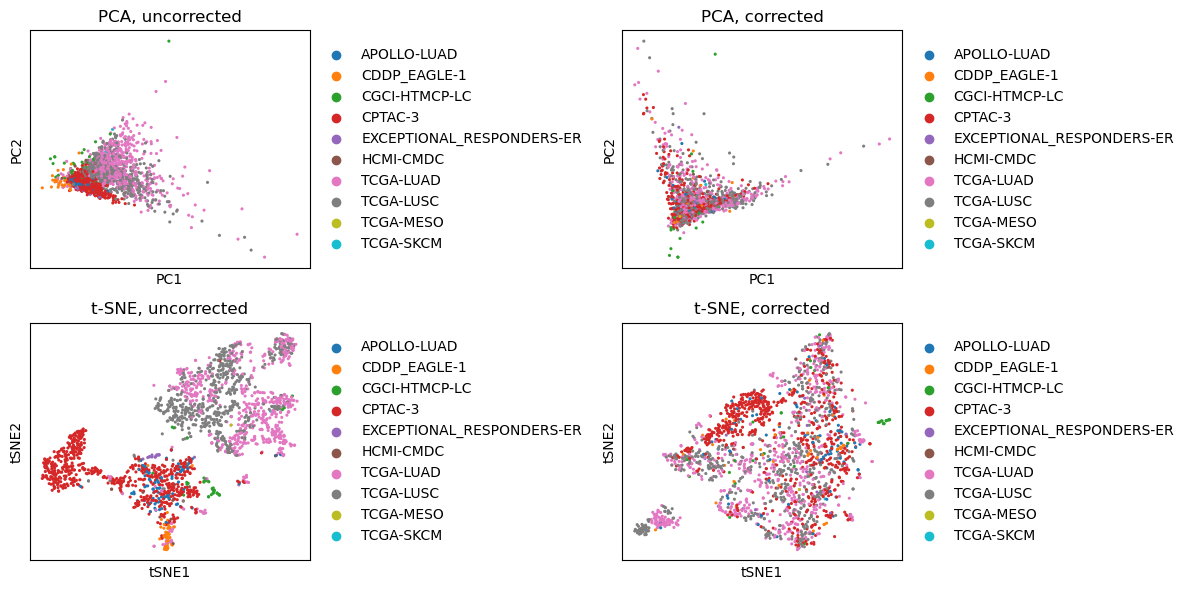

In [135]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sc.pl.pca(adata_subset_label, color=["Project ID"], dimensions=[(0, 1)], size=20, ax=axs[0, 0], show=False)
sc.pl.pca(exp_corrected,      color=["Project ID"], dimensions=[(0, 1)], size=20, ax=axs[0, 1], show=False)
sc.pl.tsne(adata_subset_label, color=["Project ID"], size=20, ax=axs[1, 0], show=False)
sc.pl.tsne(exp_corrected,      color=["Project ID"], size=20, ax=axs[1, 1], show=False)


axs[0, 0].set_title("PCA, uncorrected")
axs[0, 1].set_title("PCA, corrected")
axs[1, 0].set_title("t-SNE, uncorrected")
axs[1, 1].set_title("t-SNE, corrected")

plt.tight_layout()
plt.show()


In [ ]:
# Save files.
adata_subset_label.write("./tpm_unstranded_subset_uncorrected.h5ad")
exp_corrected.write("./tpm_unstranded_subset_corrected.h5ad")